In [1]:
from __future__ import print_function
import os
import numpy as np
from sompy.sompy import SOMFactory

In [2]:
import numpy as np;
import pandas as pd;
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
#import seaborn as sns
%matplotlib inline
# Import the data
tracks = pd.read_csv("../Data/tracks.csv",low_memory=False,header = [0,1],index_col=0)
echonest = pd.read_csv("../Data/echonest.csv",low_memory = False,header = [0,1,2],index_col=0)

In [4]:
tracks.index.rename("Track_ID",inplace=True)
print(tracks.index.name)
echonest.index.rename("Track_ID",inplace=True)
print(echonest.index.name)

echonest_audio_features = echonest['echonest', 'audio_features']
echonest_audio_features.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
Track_ID,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


In [50]:
data_with_target = pd.merge(echonest_audio_features,tracks.iloc[:,tracks.columns.get_level_values(1).isin(["genre_top"])],how = "left",left_index = True , right_index = True)
data_with_target.head()

/Applications/anaconda/lib/python3.5/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,"(track, genre_top)"
Track_ID,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


In [69]:
data_with_target.index.name

data_with_target.rename(columns = {('track', 'genre_top') : "Target_Genre"},inplace = True)

print(data_with_target['Target_Genre'].isnull().sum())

data_with_target.dropna(axis = 0,how = 'any',inplace = True)

print(data_with_target['Target_Genre'].isnull().sum())

0
0


In [71]:
#LabelEncoding the target variable
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data_with_target['Target_Genre'])
data_with_target['Target_Genre'] = le.transform(data_with_target['Target_Genre'])

echonest_audio_features.describe()

#Preparing data for Self Organizing Maps
#data = np.column_stack([echonest_audio_features,data_with_target.Target_Genre])
data = echonest_audio_features.as_matrix()

names = echonest_audio_features.columns

## Analyzing Data
<br>
<br>
There are a lot of analytical methods for analyzing data. Classical statistical methods generally include hypothesis testing, linear regression. Machine learning methods include Random Forests , Bagging and other ensemble methods.
<br>
<br>
There are also different visual techniques that can be used for data analysis. They are basically classified into two types:
<br>
1. Univariate representations which produce representations of one variable. Examples of this are histograms, box-whisker plots etc.
<br>
2. Multivariate representations try to establish and visualize the relationship between several variables. Example of this method is Self Organizing Maps (Kohonen maps).

### Basic Theory
<br>
<br>
1. There are 'n' input neurons corresponding to the 'n' data points which are mapped to 2-dimensional topological map of competing neurons.
<br>
2. Generally the compteting neurons are arranged in a 2 dimensional lattice; they are located at the corners of the lattice.
<br>
3. Each competing neuron is connected to all the input neurons.
<br>
4. There is a N-dimensional weight vector associated to each link between the input and the compteting neuron where N is the number of dimensions of the input data.
<br>
5. The competing neuron which is closest to a particular training data is called as the winning neuron and the neurons in the topographic neighborhood of this winning neuron are called as the exciting neurons. The closeness is determined by the distance between the input data point and the weight link associated with the winning neuron and the input data. This distance is calculated in the N-dimensional space. (Generally Euclidean distance is used for the same)
<br>
6. This winning neuron is called as the Best Matching Unit (BMU) for that input data.
<br>
7. The weight is updated after the BMU for a particular data point is found. The weights of the excited neurons and the input data point are also updated. This is to ensure the topological structure is maintained.
<br>
8. This process is generally carried out in two steps : Rough training and Fine training.
<br>
9. The rough training phase has a large initial learning rate and a large neighborhood radius for considering excited neurons.
<br>
10. Fine training phase has a small learning rate and a small neighborhood radius for considering excited neurons.

### Determining the quality of the Self Organizing Map
<br>
<br>
The quality of the SOM is determined by generally two metrics.
<br>
1. Quantization error : Measures the distance between each training poing and it's best matching unit. It measures map resolution.
<br>
2. Topographic error : Measures the proportion of data points for which the first and the second best matching units are not adjacent to each other.

### Implementing Self Organizing Maps

Using Sompy library in python to implement Self Organizing Maps.
<br>
1. build is a static function of the class SOMFactory
<br>
2. Data is the input data which has to be a matrix where rows are the training points and columns represent the features.
<br>
3. Initialization can be pca or random. PCA gives better results over random. 
<br>
4. Normalization uses Variance. The covariance matrix of the input data is used for finding the first two eigen values and eigen vectors for pca of the data.
<br>
5. The topographic map is initialized by the first two eigen values only.
<br>
<br>
We tried random initializations as well, but pca initialization performs better than random. Hence pca initialization is used.


In [62]:
sm = SOMFactory.build(data,normalization = 'var', initialization = 'pca',component_names=names)

 * Since we are not parallelizing the alogrithm, n_jobs = 1 and no shared memory. 
<br>
 * train_rough_len is the number of iterations for rough training
<br>
 * train_finetune_len is the number of iterations for fine training
<br>

In [63]:
sm.train(n_job = 1, shared_memory='no',verbose = 'debug',train_rough_len=500, train_finetune_len=200)

 Training...
--------------------------------------------------------------
 details: 
      > data len is 13129 and data dimension is 8
      > map size is 24,24
      > array size in log10 scale is 7.781744118742183
      > number of jobs in parallel: 1
 -------------------------------------------------------------

 pca_linear_initialization took: 0.024000 seconds
 Rough training...
 radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 500

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.005000 seconds
 epoch: 1 ---> elapsed time:  0.232000, quantization error: 2.076228

 find_bmu took: 0.223000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 2 ---> elapsed time:  0.235000, quantization error: 1.941512

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 3 ---> elapsed time:  0.230000, quantization error: 1.769856

 find_bmu took: 0.223000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 4 --->

 find_bmu took: 0.217000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 52 ---> elapsed time:  0.226000, quantization error: 1.498763

 find_bmu took: 0.220000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 53 ---> elapsed time:  0.230000, quantization error: 1.497949

 find_bmu took: 0.222000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 54 ---> elapsed time:  0.232000, quantization error: 1.497235

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 55 ---> elapsed time:  0.232000, quantization error: 1.496638

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 56 ---> elapsed time:  0.231000, quantization error: 1.495941

 find_bmu took: 0.113000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 57 ---> elapsed time:  0.123000, quantization error: 1.495240

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch:

 find_bmu took: 0.224000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 106 ---> elapsed time:  0.233000, quantization error: 1.461229

 find_bmu took: 0.217000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 107 ---> elapsed time:  0.227000, quantization error: 1.460541

 find_bmu took: 0.110000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 108 ---> elapsed time:  0.120000, quantization error: 1.459798

 find_bmu took: 0.222000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 109 ---> elapsed time:  0.231000, quantization error: 1.459130

 find_bmu took: 0.222000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 110 ---> elapsed time:  0.232000, quantization error: 1.458478

 find_bmu took: 0.222000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 111 ---> elapsed time:  0.232000, quantization error: 1.457856

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 

 find_bmu took: 0.223000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 160 ---> elapsed time:  0.233000, quantization error: 1.424234

 find_bmu took: 0.218000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 161 ---> elapsed time:  0.228000, quantization error: 1.423535

 find_bmu took: 0.212000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 162 ---> elapsed time:  0.223000, quantization error: 1.422818

 find_bmu took: 0.111000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 163 ---> elapsed time:  0.122000, quantization error: 1.422130

 find_bmu took: 0.223000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 164 ---> elapsed time:  0.233000, quantization error: 1.421339

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 165 ---> elapsed time:  0.224000, quantization error: 1.420635

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 

 find_bmu took: 0.224000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 214 ---> elapsed time:  0.234000, quantization error: 1.382831

 find_bmu took: 0.224000 seconds
 update_codebook_voronoi took: 0.005000 seconds
 epoch: 215 ---> elapsed time:  0.235000, quantization error: 1.382005

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 216 ---> elapsed time:  0.230000, quantization error: 1.381127

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 217 ---> elapsed time:  0.232000, quantization error: 1.380256

 find_bmu took: 0.224000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 218 ---> elapsed time:  0.234000, quantization error: 1.379395

 find_bmu took: 0.113000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 219 ---> elapsed time:  0.122000, quantization error: 1.378605

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 268 ---> elapsed time:  0.231000, quantization error: 1.336794

 find_bmu took: 0.224000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 269 ---> elapsed time:  0.233000, quantization error: 1.335875

 find_bmu took: 0.220000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 270 ---> elapsed time:  0.231000, quantization error: 1.334966

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 271 ---> elapsed time:  0.231000, quantization error: 1.334100

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 272 ---> elapsed time:  0.231000, quantization error: 1.333202

 find_bmu took: 0.217000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 273 ---> elapsed time:  0.227000, quantization error: 1.332310

 find_bmu took: 0.110000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 322 ---> elapsed time:  0.231000, quantization error: 1.289702

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 323 ---> elapsed time:  0.225000, quantization error: 1.288823

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 324 ---> elapsed time:  0.231000, quantization error: 1.287949

 find_bmu took: 0.216000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 325 ---> elapsed time:  0.227000, quantization error: 1.286946

 find_bmu took: 0.218000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 326 ---> elapsed time:  0.229000, quantization error: 1.286029

 find_bmu took: 0.218000 seconds
 update_codebook_voronoi took: 0.005000 seconds
 epoch: 327 ---> elapsed time:  0.229000, quantization error: 1.285133

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 

 find_bmu took: 0.218000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 376 ---> elapsed time:  0.229000, quantization error: 1.240782

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.005000 seconds
 epoch: 377 ---> elapsed time:  0.228000, quantization error: 1.239812

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.005000 seconds
 epoch: 378 ---> elapsed time:  0.226000, quantization error: 1.238834

 find_bmu took: 0.216000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 379 ---> elapsed time:  0.227000, quantization error: 1.237917

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 380 ---> elapsed time:  0.226000, quantization error: 1.237021

 find_bmu took: 0.216000 seconds
 update_codebook_voronoi took: 0.003000 seconds
 epoch: 381 ---> elapsed time:  0.226000, quantization error: 1.235951

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 

 find_bmu took: 0.218000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 430 ---> elapsed time:  0.228000, quantization error: 1.185836

 find_bmu took: 0.218000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 431 ---> elapsed time:  0.228000, quantization error: 1.184790

 find_bmu took: 0.216000 seconds
 update_codebook_voronoi took: 0.006000 seconds
 epoch: 432 ---> elapsed time:  0.228000, quantization error: 1.183699

 find_bmu took: 0.216000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 433 ---> elapsed time:  0.227000, quantization error: 1.182700

 find_bmu took: 0.216000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 434 ---> elapsed time:  0.226000, quantization error: 1.181592

 find_bmu took: 0.217000 seconds
 update_codebook_voronoi took: 0.005000 seconds
 epoch: 435 ---> elapsed time:  0.229000, quantization error: 1.180515

 find_bmu took: 0.213000 seconds
 update_codebook_voronoi took: 0.005000 seconds
 

 find_bmu took: 0.222000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 484 ---> elapsed time:  0.232000, quantization error: 1.129655

 find_bmu took: 0.222000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 485 ---> elapsed time:  0.233000, quantization error: 1.128521

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 486 ---> elapsed time:  0.225000, quantization error: 1.127388

 find_bmu took: 0.214000 seconds
 update_codebook_voronoi took: 0.003000 seconds
 epoch: 487 ---> elapsed time:  0.224000, quantization error: 1.126160

 find_bmu took: 0.227000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 488 ---> elapsed time:  0.238000, quantization error: 1.125019

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 489 ---> elapsed time:  0.232000, quantization error: 1.123917

 find_bmu took: 0.224000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 

 epoch: 37 ---> elapsed time:  0.234000, quantization error: 1.109387

 find_bmu took: 0.218000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 38 ---> elapsed time:  0.229000, quantization error: 1.109387

 find_bmu took: 0.217000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 39 ---> elapsed time:  0.227000, quantization error: 1.109387

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 40 ---> elapsed time:  0.225000, quantization error: 1.109387

 find_bmu took: 0.222000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 41 ---> elapsed time:  0.233000, quantization error: 1.109387

 find_bmu took: 0.216000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 42 ---> elapsed time:  0.226000, quantization error: 1.109387

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 43 ---> elapsed time:  0.232000, quantization error: 1.109387

 find_bmu took: 0

 epoch: 91 ---> elapsed time:  0.233000, quantization error: 1.109387

 find_bmu took: 0.223000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 92 ---> elapsed time:  0.234000, quantization error: 1.109387

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 93 ---> elapsed time:  0.229000, quantization error: 1.109387

 find_bmu took: 0.216000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 94 ---> elapsed time:  0.226000, quantization error: 1.109387

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 95 ---> elapsed time:  0.231000, quantization error: 1.109387

 find_bmu took: 0.113000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 96 ---> elapsed time:  0.123000, quantization error: 1.109387

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 97 ---> elapsed time:  0.230000, quantization error: 1.109387

 find_bmu took: 0

 update_codebook_voronoi took: 0.004000 seconds
 epoch: 145 ---> elapsed time:  0.225000, quantization error: 1.109387

 find_bmu took: 0.219000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 146 ---> elapsed time:  0.230000, quantization error: 1.109387

 find_bmu took: 0.215000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 147 ---> elapsed time:  0.225000, quantization error: 1.109387

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 148 ---> elapsed time:  0.230000, quantization error: 1.109387

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 149 ---> elapsed time:  0.231000, quantization error: 1.109387

 find_bmu took: 0.111000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 150 ---> elapsed time:  0.121000, quantization error: 1.109387

 find_bmu took: 0.217000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 151 ---> elapsed time:  0.

 find_bmu took: 0.221000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 199 ---> elapsed time:  0.231000, quantization error: 1.109387

 find_bmu took: 0.218000 seconds
 update_codebook_voronoi took: 0.004000 seconds
 epoch: 200 ---> elapsed time:  0.228000, quantization error: 1.109387

 --------------------------------------------------------------
 Final quantization error: 1.109387
 train took: 158.677000 seconds


In [64]:
topographic_error = sm.calculate_topographic_error()
quantization_error = np.mean(sm._bmu[1])
print ("Topographic error = %s\nQuantization error = %s" % (topographic_error, quantization_error))

 find_bmu took: 0.219000 seconds
 find_bmu took: 0.224000 seconds


Topographic error = 0.0
Quantization error = 1.10938676849


### Components Map
<br>
The components map or the components plane provides qualitative information about how the input variables are related to each other for the given dataset. 
<br>
<br>
The color code represents quantitative information about a particular feature and comparision of the component maps of two or more features sheds light on how these features are related to each other.

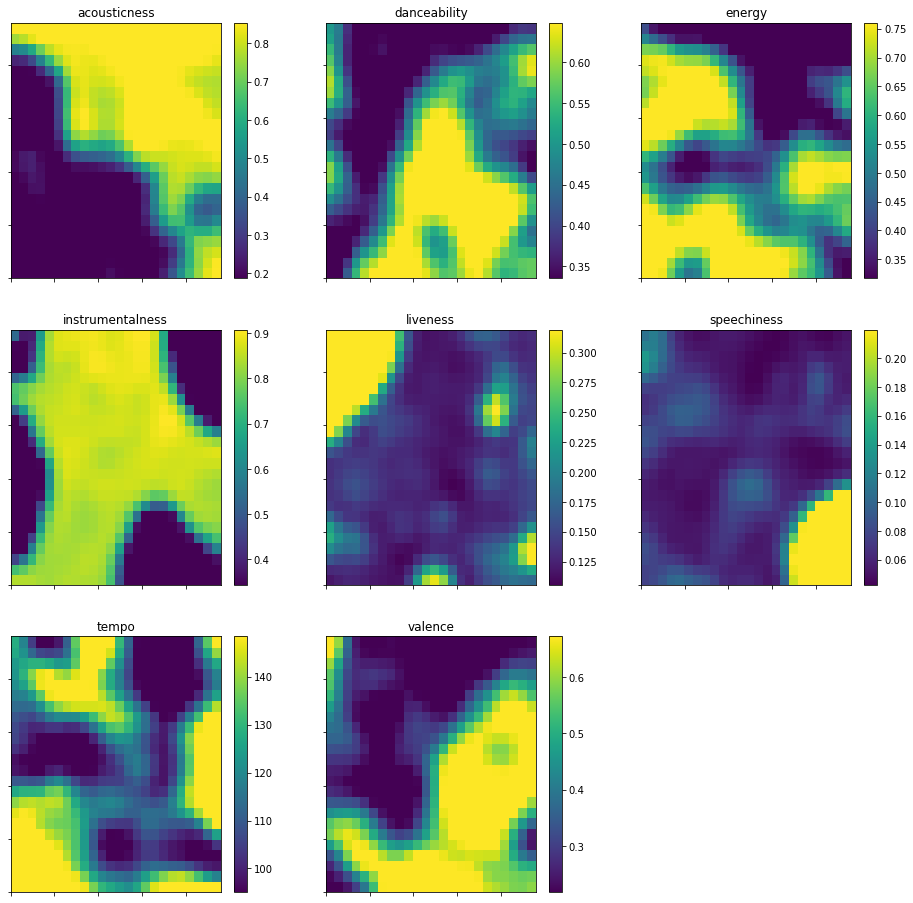

In [67]:
from sompy.visualization.mapview import View2D
view2D  = View2D(20,20,title = 'Yes',text_size=10)
view2D.show(sm, col_sz=3, which_dim="all", desnormalize=True)

### Analysis from component maps 
<br>
Important analysis from the component maps are :
<br>
1. Acoustiness and energy are negatively correlated. Points that have high acoustiness generally have low energy and vice versa.
<br>
2. Points having high tempo have high energy.
<br>
3. High dancebility points generally have high energy as well.
<br>

### Hit Map View
<br>
1. Hit map view provides quantitative information about how many times each map unit or competitive neuron was the Best Matching Unit for the input data.
<br>
2. This gives an idea of how many input data points are closely associated to a particular competitive neuron in the 2-dimensional topographic space.
<br>
3. This sheds some light on the relative importance of the competitive neurons for the given dataset.


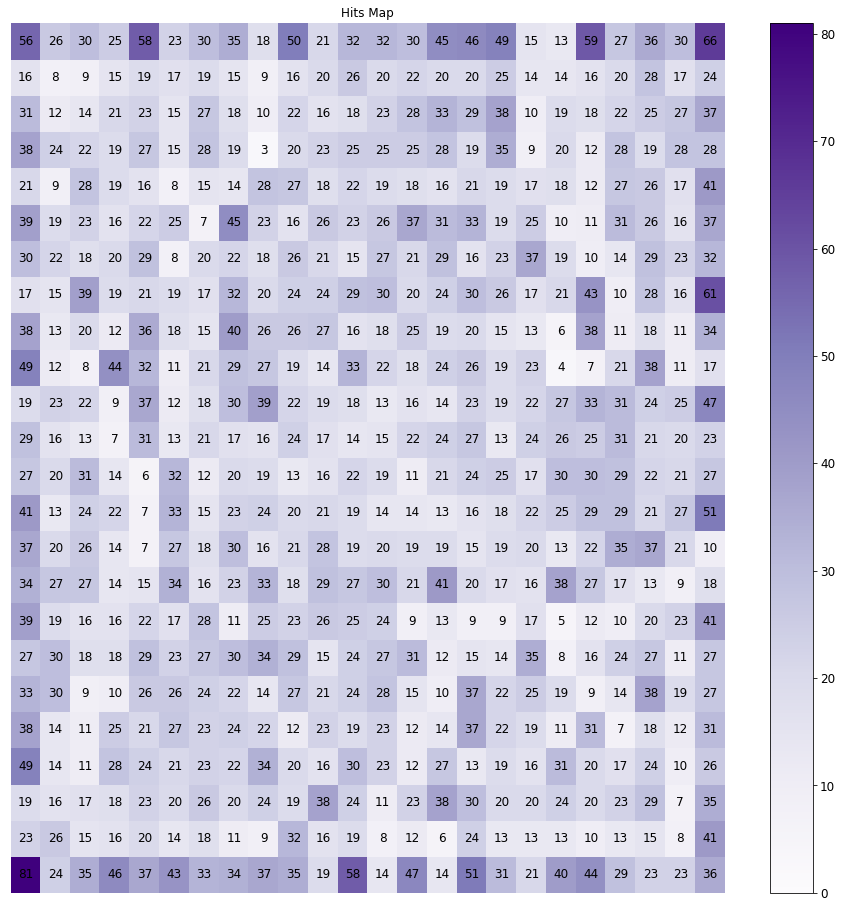

In [68]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(5,5,"Hits Map",text_size=12)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Purples", logaritmic=False)

###  Cluster the data using K-means clustering
<br>
The data is clustered using k-means clustering.
<br>
1. Number of clusters chosen here is 12 since there are 12 unique genres in the dataset.
<br>
2. The default parameter used for clustering in the library is k = 8.
<br>
3. However since a mapsize of 24 x 24 was considered, the clusters are not very prominent for all the genres.
<br>
4. Interesting analysis however is that genres 'Rock' and 'International' are close. They represent similar acoustic measures.
<br>
5. Similar is the case with genres 'Blues' and 'Pop'.
<br>
<br>
Genres represented by labels are :
<br>
0 : 'Rock'
<br>
1 : 'Electronic'
<br>
2 : 'Classical'
<br>
3 : 'Folk'
<br>
4 : 'Hip-Hop'
<br>
5 : 'Blues'
<br>
6 : 'International'
<br>
7 : 'Instrumental'
<br>
8 : 'Experimental'
<br>
9 : 'Pop'
<br>
10 : 'Old-Time / Historic'
<br>
11 :  'Jazz'

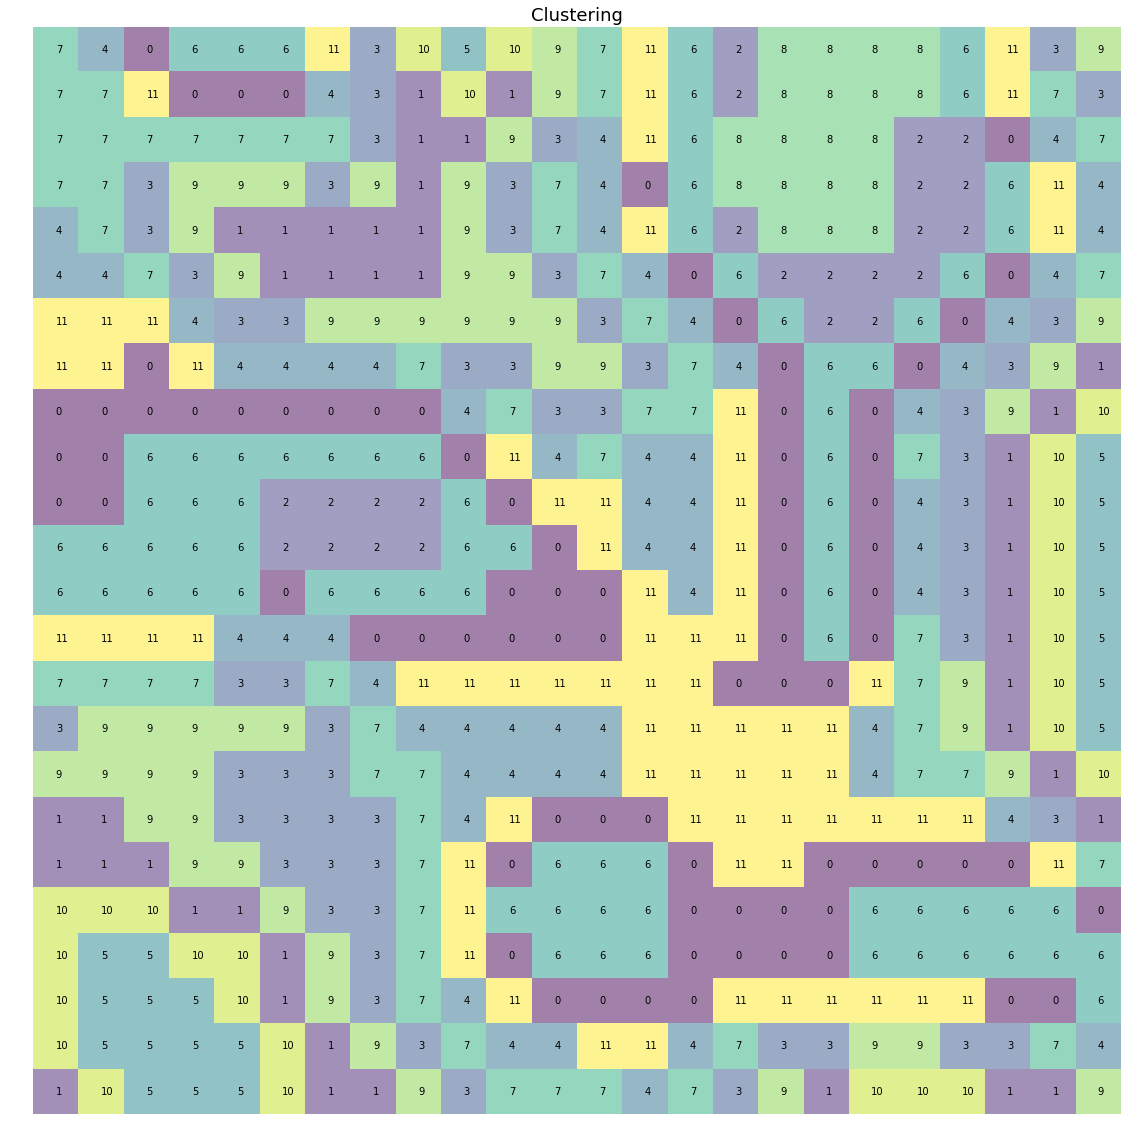

In [43]:
from sompy.visualization.hitmap import HitMapView
sm.cluster(12)
hits  = HitMapView(20,20,"Clustering",text_size=15)
a=hits.show(sm)
